In [4]:
import sys
import os
import time
import asyncio
import aiohttp
import requests
import pandas as pd
import tldextract
import ssl
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from io import BytesIO
from PIL import Image, UnidentifiedImageError
import imagehash
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import undetected_chromedriver as uc
from selenium_stealth import stealth
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio
from time import sleep
from urllib.parse import urlparse

# On Windows, force the Selector Event Loop Policy to avoid socket errors.
if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

# Apply nest_asyncio immediately for Jupyter compatibility.
nest_asyncio.apply()

# Load the Parquet file containing your domains.
df = pd.read_parquet("logos.snappy.parquet", engine="fastparquet")
domains = df['domain'].tolist()

# Ensure the directory for logos exists.
os.makedirs("logos", exist_ok=True)

# Lowered concurrency parameters.
CONCURRENT_REQUESTS = 20  # Lowered from 50
semaphore = asyncio.Semaphore(CONCURRENT_REQUESTS)

# ---- DEDUPLICATION SETUP ----
# This dictionary will store the computed hash for each domain’s logo.
saved_logo_hashes = {}

def is_duplicate_logo(new_logo_path, domain, threshold=5):
    """Compute the average hash of the new logo and compare to saved ones.
       If the difference is below threshold for a different domain, consider it a duplicate."""
    try:
        new_hash = imagehash.average_hash(Image.open(new_logo_path))
    except Exception as e:
        print(f"Error computing hash for {domain}: {e}")
        return False
    for saved_domain, saved_hash in saved_logo_hashes.items():
        if saved_domain != domain and (new_hash - saved_hash) < threshold:
            print(f"Duplicate detected: {domain} logo is similar to logo from {saved_domain}")
            return True
    # If not duplicate, store the hash.
    saved_logo_hashes[domain] = new_hash
    return False

# ---- ASYNC HTML EXTRACTION ----
async def extract_logo_html(session, domain):
    """Extract logo URL from HTML source using both HTTPS and HTTP."""
    async with semaphore:
        for protocol in ["https", "http"]:
            url = f"{protocol}://{domain}"
            try:
                async with session.get(url, timeout=10, ssl=False) as response:
                    if response.status != 200:
                        continue
                    html = await response.text()
                    soup = BeautifulSoup(html, "html.parser")
                    for img in soup.find_all("img"):
                        alt = img.get("alt", "").lower()
                        src = img.get("src", "").lower()
                        if "logo" in alt or "logo" in src:
                            return urljoin(url, img.get("src"))
            except Exception as e:
                print(f"⚠️ {protocol.upper()} failed for {domain}: {e}")
        print(f"❌ HTML extraction failed for {domain}")
        return None

# ---- ASYNC FAVICON RETRIEVAL ----
async def get_favicon(session, domain, max_retries=10, timeout=20):
    """Try to fetch the favicon using aiohttp with a few retries."""
    root_domain = tldextract.extract(domain).registered_domain
    favicon_url = f"https://{root_domain}/favicon.ico"
    for attempt in range(max_retries):
        try:
            async with session.get(favicon_url, timeout=timeout) as response:
                if response.status == 200:
                    return favicon_url
        except Exception as e:
            print(f"⚠️ Favicon fetch error for {domain} (attempt {attempt+1}/{max_retries}): {e}")
        await asyncio.sleep(1)
    print(f"❌ Failed to fetch favicon for {domain} after {max_retries} attempts.")
    return None

# ---- SELENIUM RETRIEVAL (WRAPPED IN EXECUTOR) ----
async def get_logo_selenium_async(loop, driver, domain, max_retries=5):
    """Wrap the Selenium call in a retry loop to fetch logos on JS-heavy sites."""
    def get_logo_selenium(driver, domain):
        try:
            url = f"https://{domain}"
            driver.get(url)
            time.sleep(5)  # Blocking sleep – allow images to load.
            logo_elements = driver.find_elements(By.TAG_NAME, "img")
            for img in logo_elements:
                logo_url = img.get_attribute("src")
                alt_text = img.get_attribute("alt")
                if logo_url and ("logo" in logo_url.lower() or (alt_text and "logo" in alt_text.lower())):
                    return logo_url
        except Exception as e:
            print(f"❌ Selenium failed for {domain}: {e}")
        return None

    for attempt in range(max_retries):
        result = await loop.run_in_executor(None, get_logo_selenium, driver, domain)
        if result:
            return result
        else:
            print(f"⚠️ Selenium retry {attempt+1}/{max_retries} for {domain}")
            await asyncio.sleep(2)
    return None

# ---- DOWNLOAD LOGO ----
def download_logo(url, domain):
    """Download the logo image if it does not already exist, and check for duplicates."""
    if url.startswith("data:image"):
        print(f"⚠️ Skipping data URL for {domain}.")
        return False
    logo_path = f"logos/{domain}.png"
    if os.path.exists(logo_path):
        print(f"🔄 Logo for {domain} already exists. Skipping download.")
        return True
    try:
        response = requests.get(url, timeout=10, stream=True)
        if response.status_code == 200:
            img_data = BytesIO(response.content)
            try:
                img = Image.open(img_data)
                img.save(logo_path)
                # Check for duplicates using perceptual hash.
                if is_duplicate_logo(logo_path, domain):
                    print(f"❌ Duplicate logo detected for {domain}. Removing file.")
                    os.remove(logo_path)
                    return False
                print(f"✅ Logo saved for {domain}")
                return True
            except UnidentifiedImageError:
                print(f"❌ Error saving logo for {domain}: cannot identify image file")
                return False
    except Exception as e:
        print(f"❌ Error saving logo for {domain}: {e}")
    return False

# ---- MAIN PIPELINE FUNCTION ----
async def process_domain(session, loop, driver, domain):
    """Try multiple methods to get a logo URL and download it."""
    # First, try HTML extraction.
    logo_url = await extract_logo_html(session, domain)
    # If that fails, try retrieving the favicon.
    if not logo_url:
        logo_url = await get_favicon(session, domain)
    # If favicon retrieval fails, try Selenium.
    if not logo_url:
        logo_url = await get_logo_selenium_async(loop, driver, domain)
    if logo_url:
        return download_logo(logo_url, domain)
    print(f"❌ No logo found for {domain}")
    return False

# ---- RUN ASYNC TASKS ----
async def run_async_tasks(batch_size=50):  # Reduced batch size from 100 to 50
    """Main async function to run logo extraction across all domains."""
    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--window-size=1920,1080")

    driver = uc.Chrome(options=options, headless=True)
    stealth(driver, languages=["en-US", "en"], vendor="Google Inc.", platform="Win32",
            webgl_vendor="Intel Inc.", renderer="Intel Iris OpenGL Engine", fix_hairline=True)
    driver.set_page_load_timeout(15)

    loop = asyncio.get_running_loop()
    total_results = []
    # Process domains in batches.
    for i in range(0, len(domains), batch_size):
        batch = domains[i:i+batch_size]
        print(f"Processing batch {i//batch_size+1} with {len(batch)} domains")
        # Use a TCPConnector with a limit to restrict the number of open sockets.
        connector = aiohttp.TCPConnector(limit=20)
        async with aiohttp.ClientSession(connector=connector) as session:
            try:
                tasks = [process_domain(session, loop, driver, domain) for domain in batch]
                batch_results = await asyncio.gather(*tasks, return_exceptions=True)
                total_results.extend(batch_results)
            except OSError as ose:
                print(f"OSError encountered during batch processing: {ose}")
        await asyncio.sleep(2)
    driver.quit()
    return total_results


In [5]:
results = await run_async_tasks()
print(f"{sum(results)} logos saved")



could not detect version_main.therefore, we are assuming it is chrome 108 or higher


Processing batch 1 with 50 domains
⚠️ HTTPS failed for ymcasteuben.org: Cannot connect to host ymcasteuben.org:443 ssl:False [[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:992)]
❌ HTML extraction failed for ymcasteuben.org
⚠️ Favicon fetch error for ymcasteuben.org (attempt 1/10): Cannot connect to host ymcasteuben.org:443 ssl:default [[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:992)]
🔄 Logo for freseniusmedicalcare.ca already exists. Skipping download.
⚠️ HTTPS failed for greatplacetowork.com.bo: Cannot connect to host greatplacetowork.com.bo:443 ssl:False [None]
🔄 Logo for kia-moeller-wunstorf.de already exists. Skipping download.
🔄 Logo for plameco-hannover.de already exists. Skipping download.
❌ Error saving logo for autosecuritas-ct-seysses.fr: cannot identify image file
❌ Error saving logo for synlab.com.tr: cannot identify image file
🔄 Logo for toyota-buchreiter-eisenstadt.at already exists. Skipping download.
❌ Error s

CancelledError: 

Processing batch 1 with 50 domains
⚠️ HTTPS failed for ymcasteuben.org: Cannot connect to host ymcasteuben.org:443 ssl:False [[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:992)]
❌ HTML extraction failed for ymcasteuben.org
Invalid logo URL: https://logo.clearbit.com/ymcasteuben.org for domain ymcasteuben.org (expected ymcasteuben.org)
⚠️ Favicon fetch error for ymcasteuben.org (attempt 1/10): Cannot connect to host ymcasteuben.org:443 ssl:default [[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:992)]
🔄 Logo for freseniusmedicalcare.ca already exists. Skipping download.
⚠️ HTTPS failed for greatplacetowork.com.bo: Cannot connect to host greatplacetowork.com.bo:443 ssl:False [None]
🔄 Logo for kia-moeller-wunstorf.de already exists. Skipping download.
Invalid logo URL: https://www.autosecuritas.fr/public/img/showcase/autosecuritas-logo.svg for domain autosecuritas-ct-seysses.fr (expected autosecuritas-ct-seysses.fr)
❌ Error saving lo

CancelledError: 

❌ Selenium failed for besins-healthcare.se: Message: stale element reference: stale element not found
  (Session info: chrome=134.0.6998.89); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
	GetHandleVerifier [0x003EB5A3+24387]
	(No symbol) [0x00375904]
	(No symbol) [0x00250753]
	(No symbol) [0x00262361]
	(No symbol) [0x00261440]
	(No symbol) [0x00257B90]
	(No symbol) [0x00257C6C]
	(No symbol) [0x00255F7A]
	(No symbol) [0x00259615]
	(No symbol) [0x002E0125]
	(No symbol) [0x002BD84C]
	(No symbol) [0x002DF138]
	(No symbol) [0x002BD646]
	(No symbol) [0x0028C59F]
	(No symbol) [0x0028D8E4]
	GetHandleVerifier [0x006ED883+3179043]
	GetHandleVerifier [0x00706CF9+3282585]
	GetHandleVerifier [0x0070167C+3260444]
	GetHandleVerifier [0x00484330+650448]
	(No symbol) [0x0037ED0D]
	(No symbol) [0x0037BAF8]
	(No symbol) [0x0037BC99]
	(No symbol) [0x0036E530]
	BaseThreadInitThunk [0x7581
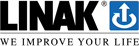
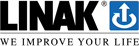

In [1]:
import sys
import os
import time
import asyncio
import aiohttp
import requests
import pandas as pd
import tldextract
import ssl
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from io import BytesIO
from PIL import Image, UnidentifiedImageError
import imagehash
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import undetected_chromedriver as uc
from selenium_stealth import stealth
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio
from time import sleep

# On Windows, force the Selector Event Loop Policy to avoid socket errors.
if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

# Apply nest_asyncio immediately for Jupyter compatibility.
nest_asyncio.apply()

# Load the Parquet file containing your domains.
df = pd.read_parquet("logos.snappy.parquet", engine="fastparquet")
domains = df['domain'].tolist()

# Ensure the directory for logos exists.
os.makedirs("logos", exist_ok=True)

# Concurrency semaphore
CONCURRENT_REQUESTS = 20  # Adjust as needed
semaphore = asyncio.Semaphore(CONCURRENT_REQUESTS)

# ---- DEDUPLICATION SETUP ----
saved_logo_hashes = {}

def is_duplicate_logo(new_logo_path, domain, threshold=5):
    """Compute the average hash of the new logo and compare to saved ones."""
    try:
        new_hash = imagehash.average_hash(Image.open(new_logo_path))
    except Exception as e:
        print(f"Error computing hash for {domain}: {e}")
        return False
    for saved_domain, saved_hash in saved_logo_hashes.items():
        if saved_domain != domain and (new_hash - saved_hash) < threshold:
            print(f"Duplicate detected: {domain} logo is similar to logo from {saved_domain}")
            return True
    saved_logo_hashes[domain] = new_hash
    return False

def is_valid_logo_url(logo_url, domain):
    """
    Verify that the logo URL corresponds to the expected domain.
    For example, if domain is isuzu.com and logo_url is from linde.com, return False.
    """
    try:
        logo_host = urlparse(logo_url).netloc.lower()
        expected_domain = tldextract.extract(domain).registered_domain.lower()
        logo_registered_domain = tldextract.extract(logo_host).registered_domain.lower()
        if expected_domain == logo_registered_domain:
            return True
        else:
            print(f"Invalid logo URL: {logo_url} for domain {domain} (expected {expected_domain})")
            return False
    except Exception as e:
        print(f"Error validating logo URL for {domain}: {e}")
        return False

def extract_logo_from_metadata(soup, base_url):
    """
    Look for structured metadata tags that might contain the logo URL.
    Checks for og:image and twitter:image.
    """
    meta_tag = soup.find("meta", property="og:image")
    if meta_tag and meta_tag.get("content"):
        return urljoin(base_url, meta_tag.get("content"))
    meta_tag = soup.find("meta", attrs={"name": "twitter:image"})
    if meta_tag and meta_tag.get("content"):
        return urljoin(base_url, meta_tag.get("content"))
    return None

def get_logo_clearbit(domain):
    """
    Use Clearbit Logo API as a fallback.
    This service returns the logo for a given domain.
    """
    return f"https://logo.clearbit.com/{domain}"

def is_valid_image(img):
    """Check that the image meets quality requirements (e.g., minimum size)."""
    min_size = (100, 100)
    if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
        print(f"Image too small: {img.size}")
        return False
    return True

# ---- ASYNC HTML EXTRACTION ----
async def extract_logo_html(session, domain):
    """Extract logo URL from HTML source using HTTPS and HTTP, leveraging metadata if available."""
    async with semaphore:
        for protocol in ["https", "http"]:
            url = f"{protocol}://{domain}"
            try:
                async with session.get(url, timeout=10, ssl=False) as response:
                    if response.status != 200:
                        continue
                    html = await response.text()
                    soup = BeautifulSoup(html, "html.parser")
                    
                    # First try metadata extraction
                    logo_url = extract_logo_from_metadata(soup, url)
                    if logo_url and is_valid_logo_url(logo_url, domain):
                        return logo_url

                    # Fallback to scanning all image tags
                    for img in soup.find_all("img"):
                        alt = img.get("alt", "").lower()
                        src = img.get("src", "").lower()
                        if "logo" in alt or "logo" in src:
                            candidate = urljoin(url, img.get("src"))
                            if is_valid_logo_url(candidate, domain):
                                return candidate
            except Exception as e:
                print(f"⚠️ {protocol.upper()} failed for {domain}: {e}")
        print(f"❌ HTML extraction failed for {domain}")
        return None

# ---- ASYNC FAVICON RETRIEVAL ----
async def get_favicon(session, domain, max_retries=10, timeout=20):
    """Fetch the favicon from the root domain."""
    root_domain = tldextract.extract(domain).registered_domain
    favicon_url = f"https://{root_domain}/favicon.ico"
    for attempt in range(max_retries):
        try:
            async with session.get(favicon_url, timeout=timeout) as response:
                if response.status == 200:
                    if is_valid_logo_url(favicon_url, domain):
                        return favicon_url
        except Exception as e:
            print(f"⚠️ Favicon fetch error for {domain} (attempt {attempt+1}/{max_retries}): {e}")
        await asyncio.sleep(1)
    print(f"❌ Failed to fetch favicon for {domain} after {max_retries} attempts.")
    return None

# ---- SELENIUM RETRIEVAL (IMPROVED WITH EXPLICIT WAITS) ----
async def get_logo_selenium_async(loop, driver, domain, max_retries=5):
    """Use Selenium with explicit waits to fetch logos from JS-heavy sites."""
    def get_logo_selenium(driver, domain):
        try:
            url = f"https://{domain}"
            driver.get(url)
            # Wait until image tags are present.
            wait = WebDriverWait(driver, 10)
            wait.until(EC.presence_of_all_elements_located((By.TAG_NAME, "img")))
            logo_elements = driver.find_elements(By.TAG_NAME, "img")
            for img in logo_elements:
                logo_url = img.get_attribute("src")
                alt_text = img.get_attribute("alt") or ""
                if logo_url and ("logo" in logo_url.lower() or "logo" in alt_text.lower()):
                    if is_valid_logo_url(logo_url, domain):
                        return logo_url
        except Exception as e:
            print(f"❌ Selenium failed for {domain}: {e}")
        return None

    for attempt in range(max_retries):
        result = await loop.run_in_executor(None, get_logo_selenium, driver, domain)
        if result:
            return result
        else:
            print(f"⚠️ Selenium retry {attempt+1}/{max_retries} for {domain}")
            await asyncio.sleep(2)
    return None

# ---- DOWNLOAD LOGO ----
def download_logo(url, domain):
    """Download and save the logo if it meets the criteria and is not a duplicate."""
    if url.startswith("data:image"):
        print(f"⚠️ Skipping data URL for {domain}.")
        return False
    logo_path = f"logos/{domain}.png"
    if os.path.exists(logo_path):
        print(f"🔄 Logo for {domain} already exists. Skipping download.")
        return True
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
        }
        response = requests.get(url, timeout=10, stream=True, headers=headers)
        if response.status_code == 200:
            img_data = BytesIO(response.content)
            try:
                img = Image.open(img_data)
                if not is_valid_image(img):
                    print(f"❌ Invalid image quality for {domain}")
                    return False
                img.save(logo_path)
                # Check for duplicate logos using perceptual hashing.
                if is_duplicate_logo(logo_path, domain):
                    print(f"❌ Duplicate logo detected for {domain}. Removing file.")
                    os.remove(logo_path)
                    return False
                print(f"✅ Logo saved for {domain}")
                return True
            except UnidentifiedImageError:
                print(f"❌ Error saving logo for {domain}: cannot identify image file")
                return False
    except Exception as e:
        print(f"❌ Error saving logo for {domain}: {e}")
    return False

# ---- MAIN PIPELINE FUNCTION ----
async def process_domain(session, loop, driver, domain):
    """
    Try multiple methods to get a logo URL and download it.
    Order:
      1. HTML extraction (including metadata)
      2. Clearbit API fallback
      3. Favicon retrieval
      4. Selenium for JS-heavy sites
    """
    # Try HTML extraction.
    logo_url = await extract_logo_html(session, domain)
    if logo_url and is_valid_logo_url(logo_url, domain):
        if download_logo(logo_url, domain):
            return True

    # Fallback: Try Clearbit API.
    clearbit_logo = get_logo_clearbit(domain)
    if clearbit_logo and is_valid_logo_url(clearbit_logo, domain):
        if download_logo(clearbit_logo, domain):
            return True

    # Fallback: Try retrieving favicon.
    logo_url = await get_favicon(session, domain)
    if logo_url and is_valid_logo_url(logo_url, domain):
        if download_logo(logo_url, domain):
            return True

    # Fallback: Try Selenium retrieval.
    logo_url = await get_logo_selenium_async(loop, driver, domain)
    if logo_url and is_valid_logo_url(logo_url, domain):
        if download_logo(logo_url, domain):
            return True

    print(f"❌ No valid logo found for {domain}")
    return False

# ---- RUN ASYNC TASKS ----
async def run_async_tasks(batch_size=50):
    """Main async function to run logo extraction across all domains."""
    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--window-size=1920,1080")

    driver = uc.Chrome(options=options, headless=True)
    stealth(driver, languages=["en-US", "en"], vendor="Google Inc.", platform="Win32",
            webgl_vendor="Intel Inc.", renderer="Intel Iris OpenGL Engine", fix_hairline=True)
    driver.set_page_load_timeout(15)

    loop = asyncio.get_running_loop()
    total_results = []
    # Process domains in batches.
    for i in range(0, len(domains), batch_size):
        batch = domains[i:i+batch_size]
        print(f"Processing batch {i//batch_size+1} with {len(batch)} domains")
        connector = aiohttp.TCPConnector(limit=20)
        async with aiohttp.ClientSession(connector=connector) as session:
            try:
                tasks = [process_domain(session, loop, driver, domain) for domain in batch]
                batch_results = await asyncio.gather(*tasks, return_exceptions=True)
                total_results.extend(batch_results)
            except OSError as ose:
                print(f"OSError encountered during batch processing: {ose}")
        await asyncio.sleep(2)
    driver.quit()
    return total_results

# Run the asynchronous tasks and print the results.
results = await run_async_tasks()
print(f"{sum([1 for r in results if r])} logos saved")


In [3]:
import sys
import os
import time
import asyncio
import aiohttp
import requests
import pandas as pd
import tldextract
import ssl
import logging
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from io import BytesIO
from PIL import Image, UnidentifiedImageError
import imagehash
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException
import undetected_chromedriver as uc
from selenium_stealth import stealth
import urllib3
from functools import wraps
import nest_asyncio

# -----------------------------------------------------------------------------
# For Windows event loop issues in interactive environments like Jupyter:
if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())
nest_asyncio.apply()  # Allows nested event loops (required for Jupyter)

# Disable insecure request warnings (since verify=False is used in requests)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# -----------------------------------------------------------------------------
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# -----------------------------------------------------------------------------
# Retry decorator to handle stale elements in Selenium
def retry_on_stale(max_retries=3, delay=0.5):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            attempts = 0
            while attempts < max_retries:
                try:
                    return func(*args, **kwargs)
                except StaleElementReferenceException as e:
                    attempts += 1
                    domain = args[1] if len(args) > 1 else "unknown"
                    logger.warning(f"Stale element in {func.__name__} for {domain}. Retrying {attempts}/{max_retries} ...")
                    time.sleep(delay)
            logger.error(f"{func.__name__} failed after {max_retries} retries due to stale element.")
            return None
        return wrapper
    return decorator

# -----------------------------------------------------------------------------
# Load domains from parquet file
df = pd.read_parquet("logos.snappy.parquet", engine="fastparquet")
domains = df['domain'].tolist()
os.makedirs("logos", exist_ok=True)

# Concurrency semaphore for HTTP calls
CONCURRENT_REQUESTS = 20
semaphore = asyncio.Semaphore(CONCURRENT_REQUESTS)

# Deduplication storage
saved_logo_hashes: dict[str, imagehash.ImageHash] = {}

def is_duplicate_logo(new_logo_path: str, domain: str, threshold: int = 5) -> bool:
    """Compute the average hash and compare with saved logos."""
    try:
        new_hash = imagehash.average_hash(Image.open(new_logo_path))
    except Exception as e:
        logger.error(f"Error computing hash for {domain}: {e}")
        return False
    for saved_domain, saved_hash in saved_logo_hashes.items():
        if saved_domain != domain and (new_hash - saved_hash) < threshold:
            logger.info(f"Duplicate detected: {domain} logo is similar to logo from {saved_domain}")
            return True
    saved_logo_hashes[domain] = new_hash
    return False

def is_valid_logo_url(logo_url: str, domain: str) -> bool:
    """Return True if the logo URL is acceptable. Allow Clearbit fallback."""
    if "clearbit.com" in logo_url:
        return True
    try:
        logo_host = urlparse(logo_url).netloc.lower()
        expected_domain = tldextract.extract(domain).registered_domain.lower()
        logo_registered_domain = tldextract.extract(logo_host).registered_domain.lower()
        if expected_domain == logo_registered_domain:
            return True
        else:
            logger.info(f"Invalid logo URL: {logo_url} for domain {domain} (expected {expected_domain})")
            return False
    except Exception as e:
        logger.error(f"Error validating logo URL for {domain}: {e}")
        return False

def extract_logo_from_metadata(soup: BeautifulSoup, base_url: str) -> str | None:
    """Extract logo URL from meta tags (og:image, twitter:image)."""
    for attr in [("property", "og:image"), ("name", "twitter:image")]:
        tag = soup.find("meta", {attr[0]: attr[1]})
        if tag and tag.get("content"):
            return urljoin(base_url, tag.get("content"))
    return None

def get_logo_clearbit(domain: str) -> str:
    """Fallback logo URL using Clearbit."""
    return f"https://logo.clearbit.com/{domain}"

def is_valid_image(img: Image.Image) -> bool:
    """Check if the image meets the minimum size requirements."""
    min_size = (1, 1)
    if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
        logger.info(f"Image too small: {img.size}")
        return False
    return True

# -----------------------------------------------------------------------------
# ASYNC HTML EXTRACTION
async def extract_logo_html(session: aiohttp.ClientSession, domain: str) -> str | None:
    async with semaphore:
        for protocol in ["https", "http"]:
            url = f"{protocol}://{domain}"
            try:
                async with session.get(url, timeout=10) as response:
                    if response.status != 200:
                        continue
                    html = await response.text()
                    soup = BeautifulSoup(html, "html.parser")
                    # Try metadata extraction first.
                    logo_url = extract_logo_from_metadata(soup, url)
                    if logo_url and is_valid_logo_url(logo_url, domain):
                        return logo_url
                    # Fallback: iterate over all <img> tags.
                    for img in soup.find_all("img"):
                        alt_text = (img.get("alt") or "").lower()
                        src = img.get("src") or ""
                        if "logo" in alt_text or "logo" in src.lower():
                            candidate = urljoin(url, src)
                            if is_valid_logo_url(candidate, domain):
                                return candidate
            except Exception as e:
                logger.warning(f"{protocol.upper()} failed for {domain}: {e}")
        logger.error(f"HTML extraction failed for {domain}")
        return None

# -----------------------------------------------------------------------------
# ASYNC FAVICON RETRIEVAL
async def get_favicon(session: aiohttp.ClientSession, domain: str, max_retries: int = 10, timeout: int = 20) -> str | None:
    root_domain = tldextract.extract(domain).registered_domain
    favicon_url = f"https://{root_domain}/favicon.ico"
    for attempt in range(max_retries):
        try:
            async with session.get(favicon_url, timeout=timeout) as response:
                if response.status == 200:
                    if is_valid_logo_url(favicon_url, domain):
                        return favicon_url
        except Exception as e:
            logger.warning(f"Favicon fetch error for {domain} (attempt {attempt+1}/{max_retries}): {e}")
        await asyncio.sleep(1)
    logger.error(f"Failed to fetch favicon for {domain} after {max_retries} attempts.")
    return None

# -----------------------------------------------------------------------------
# SELENIUM RETRIEVAL (synchronous function wrapped in executor)
@retry_on_stale(max_retries=5, delay=0.5)
def get_logo_selenium_sync(driver: uc.Chrome, domain: str) -> str | None:
    url = f"https://{domain}"
    driver.get(url)
    wait = WebDriverWait(driver, 30)
    wait.until(EC.presence_of_all_elements_located((By.TAG_NAME, "img")))
    logo_elements = driver.find_elements(By.TAG_NAME, "img")
    for img in logo_elements:
        try:
            logo_url = img.get_attribute("src")
            alt_text = (img.get_attribute("alt") or "").lower()
            if logo_url and ("logo" in logo_url.lower() or "logo" in alt_text):
                if is_valid_logo_url(logo_url, domain):
                    return logo_url
        except StaleElementReferenceException as sere:
            logger.warning(f"Stale element encountered for {domain}: {sere}")
            raise  # Let the decorator catch and retry.
    return None

async def get_logo_selenium_async(loop: asyncio.AbstractEventLoop, driver: uc.Chrome, domain: str) -> str | None:
    return await loop.run_in_executor(None, get_logo_selenium_sync, driver, domain)

# -----------------------------------------------------------------------------
# Download and save logo image
def download_logo(url: str, domain: str) -> bool:
    """Download image, check quality, save file, and check duplicates."""
    if url.startswith("data:image"):
        logger.warning(f"Skipping data URL for {domain}.")
        return False
    logo_path = os.path.join("logos", f"{domain}.png")
    if os.path.exists(logo_path):
        logger.info(f"Logo for {domain} already exists. Skipping download.")
        return True
    headers = {
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/108.0.0.0 Safari/537.36")
    }
    try:
        with requests.get(url, timeout=10, stream=True, headers=headers, verify=False) as response:
            if response.status_code == 200:
                img_data = BytesIO(response.content)
                try:
                    img = Image.open(img_data)
                    if not is_valid_image(img):
                        logger.error(f"Invalid image quality for {domain}")
                        return False
                    img.save(logo_path)
                    if is_duplicate_logo(logo_path, domain):
                        logger.error(f"Duplicate logo detected for {domain}. Removing file.")
                        os.remove(logo_path)
                        return False
                    logger.info(f"Logo saved for {domain}")
                    return True
                except UnidentifiedImageError:
                    logger.error(f"Error saving logo for {domain}: cannot identify image file")
                    return False
    except Exception as e:
        logger.error(f"Error saving logo for {domain}: {e}")
    return False

# -----------------------------------------------------------------------------
# MAIN PIPELINE FUNCTION
async def process_domain(session: aiohttp.ClientSession, loop: asyncio.AbstractEventLoop, driver: uc.Chrome, domain: str) -> bool:
    """Attempt multiple methods to retrieve and save a logo for a given domain."""
    # 1. HTML extraction.
    logo_url = await extract_logo_html(session, domain)
    if logo_url and is_valid_logo_url(logo_url, domain):
        if download_logo(logo_url, domain):
            return True

    # 2. Clearbit fallback.
    clearbit_logo = get_logo_clearbit(domain)
    if clearbit_logo and is_valid_logo_url(clearbit_logo, domain):
        if download_logo(clearbit_logo, domain):
            return True

    # 3. Favicon retrieval.
    logo_url = await get_favicon(session, domain)
    if logo_url and is_valid_logo_url(logo_url, domain):
        if download_logo(logo_url, domain):
            return True

    # 4. Selenium retrieval.
    logo_url = await get_logo_selenium_async(loop, driver, domain)
    if logo_url and is_valid_logo_url(logo_url, domain):
        if download_logo(logo_url, domain):
            return True

    logger.error(f"No valid logo found for {domain}")
    return False

async def run_async_tasks(batch_size: int = 50) -> list[bool]:
    """Run logo extraction tasks for all domains in batches."""
    # Set up Chrome options and start undetected_chromedriver.
    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-gpu")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--ignore-certificate-errors")
    options.add_argument("--ignore-ssl-errors")

    driver = uc.Chrome(options=options, headless=True)
    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True)
    driver.set_page_load_timeout(30)

    loop = asyncio.get_running_loop()
    total_results: list[bool] = []
    # Set up an SSL context for aiohttp that does not verify certificates.
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    for i in range(0, len(domains), batch_size):
        batch = domains[i:i + batch_size]
        logger.info(f"Processing batch {i // batch_size + 1} with {len(batch)} domains")
        connector = aiohttp.TCPConnector(limit=20, ssl=ssl_context)
        async with aiohttp.ClientSession(connector=connector) as session:
            try:
                tasks = [process_domain(session, loop, driver, domain) for domain in batch]
                batch_results = await asyncio.gather(*tasks, return_exceptions=True)
                total_results.extend(batch_results)
            except OSError as ose:
                logger.error(f"OSError encountered during batch processing: {ose}")
        await asyncio.sleep(2)
    driver.quit()
    return total_results

# -----------------------------------------------------------------------------
# MAIN ENTRY POINT FOR JUPYTER NOTEBOOK
async def main():
    results = await run_async_tasks()
    saved_count = sum(1 for r in results if r is True)
    logger.info(f"\n{saved_count} logos saved out of {len(domains)} domains.")
    return results

# -----------------------------------------------------------------------------
# In a Jupyter Notebook, simply run the following cell:
results = await main()


C:\Users\vgale\AppData\Local\Programs\Python\Python311\Lib\tokenize.py:529: RuntimeWarning: coroutine 'run_async_tasks' was never awaited
  pseudomatch = _compile(PseudoToken).match(line, pos)
2025-03-16 18:47:59,838 [INFO] patching driver executable C:\Users\vgale\appdata\roaming\undetected_chromedriver\undetected_chromedriver.exe
2025-03-16 18:48:00,732 [INFO] Processing batch 1 with 50 domains
2025-03-16 18:48:00,897 [WARNING] HTTPS failed for ymcasteuben.org: Cannot connect to host ymcasteuben.org:443 ssl:default [[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:992)]
2025-03-16 18:48:00,902 [ERROR] HTML extraction failed for ymcasteuben.org
2025-03-16 18:48:00,912 [INFO] Logo for ymcasteuben.org already exists. Skipping download.
2025-03-16 18:48:01,098 [INFO] Logo for freseniusmedicalcare.ca already exists. Skipping download.
2025-03-16 18:48:01,158 [WARNING] HTTPS failed for greatplacetowork.com.bo: Cannot connect to host greatplacetowork.com.bo:443 ssl

OSError: [WinError 10038] An operation was attempted on something that is not a socket

2025-03-16 19:01:58,356 [WARNING] Stale element encountered for decathlon.hu: Message: stale element reference: stale element not found
  (Session info: chrome=134.0.6998.89); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
	GetHandleVerifier [0x0067B5A3+24387]
	(No symbol) [0x00605904]
	(No symbol) [0x004E0753]
	(No symbol) [0x004F2361]
	(No symbol) [0x004F1440]
	(No symbol) [0x004E7B90]
	(No symbol) [0x004E7C6C]
	(No symbol) [0x004E5F7A]
	(No symbol) [0x004E9615]
	(No symbol) [0x00570125]
	(No symbol) [0x0054D84C]
	(No symbol) [0x0056F138]
	(No symbol) [0x0054D646]
	(No symbol) [0x0051C59F]
	(No symbol) [0x0051D8E4]
	GetHandleVerifier [0x0097D883+3179043]
	GetHandleVerifier [0x00996CF9+3282585]
	GetHandleVerifier [0x0099167C+3260444]
	GetHandleVerifier [0x00714330+650448]
	(No symbol) [0x0060ED0D]
	(No symbol) [0x0060BAF8]
	(No symbol) [0x0060BC99]
	(No symbol) [0x005F

: 